# Data Analytics and Problem Formulation

In [1]:
from collections import Counter
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

### Load data, count sentence and document level tokens

In [2]:
df = pd.read_csv('./data_raw/data.tsv', sep='\t', encoding='latin1')

df['sent_token_count'] = df['Sentence'].apply(lambda x: len(x.split(' ')))
df_doc_token_count = df.groupby('DocumentID').sum()['sent_token_count'].reset_index(name='doc_token_count')
df = df.merge(df_doc_token_count, on='DocumentID')

In [22]:
df.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label,sent_token_count,doc_token_count
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0,10,61
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0,8,61
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0,7,61
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1,14,61
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0,22,61


### Count labels and find the dataset is very imbalanced.


In [5]:
df_label_count = df.groupby(['Label']).size().reset_index(name='count')
df_label_count

,Label,count
0,0,19308
1,1,1039


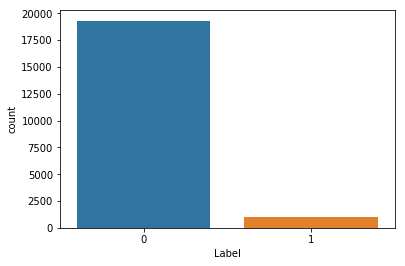

In [6]:
sns.barplot(x=df_label_count['Label'], y=df_label_count['count'])

### Count the number of sentences for each document

In [8]:
df_sent_count = df.groupby(['DocumentID']).count()['Label'].reset_index(name='sent_count')
df_sent_count = df_sent_count.sort_values('sent_count', ascending=False).reset_index(drop=True)
df_sent_count.head()

,DocumentID,sent_count
0,D359,174
1,D557,135
2,D549,60
3,D881,56
4,D125,48


In [23]:
df_sent_count.describe()

,sent_count
count,1994.000000
mean,10.204112
std,8.600515
min,1.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,174.000000


We find 75% most documents have less than 15 sentences. However, the rest 25% documents have much more sentences and **the maximum number of sentence can reach 174**, which is too long to directly feed into deep learning model.

### Count the number of answers for each document

In [11]:
df_ans_count = df.groupby('DocumentID').sum()['Label'].reset_index(name='ans_count')
df_ans_count = df_ans_count.sort_values('ans_count', ascending=False).reset_index(drop=True)
df_ans_count.head()

,DocumentID,ans_count
0,D1036,7
1,D141,7
2,D1655,6
3,D178,5
4,D359,5


In [27]:
df_ans_count.describe()

,ans_count
count,1994.000000
mean,0.521063
std,0.719458
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,7.000000


### Plot the answer count vs the document count

In [13]:
df_ans_doc_count = df_ans_count.groupby('ans_count').size().reset_index(name='doc_count')
df_ans_doc_count

,ans_count,doc_count
0,0,1143
1,1,708
2,2,115
3,3,21
4,4,2
5,5,2
6,6,1
7,7,2


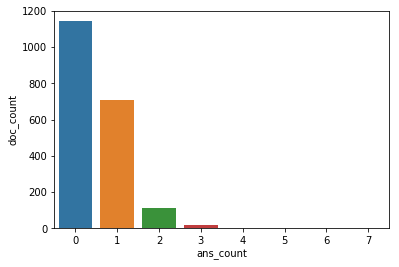

In [15]:
sns.barplot(x=df_ans_doc_count['ans_count'], y=df_ans_doc_count['doc_count'])

As we can see from the above image, most of documents do not have answers. Around 10% documents have more thant 1 answers.

### Plot the histogram of tokens at sentence level 

In [16]:
df['sent_token_count'].describe()

count    20347.000000
mean        22.747776
std         11.645560
min          1.000000
25%         15.000000
50%         21.000000
75%         29.000000
max        247.000000
Name: sent_token_count, dtype: float64

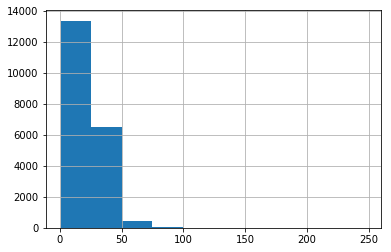

In [17]:
df['sent_token_count'].hist()

### Plot the histogram of tokens at document level 

In [25]:
df['doc_token_count'].describe()

count    20347.000000
mean       394.729592
std        437.770782
min          5.000000
25%        186.000000
50%        311.000000
75%        465.000000
max       3546.000000
Name: doc_token_count, dtype: float64

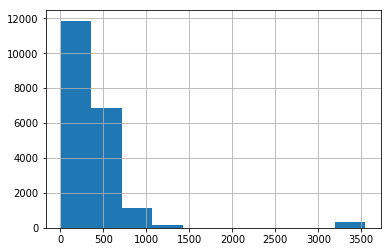

In [26]:
df['doc_token_count'].hist()

# Conclusion

This dataset can be formulated into two types of problems:
1. **Binary Text Classification:** p(label=1|question, sentence). Given a pair of question and sentence, try to calculate whether the sentence is the answer of the question. This formulation is very straightforward, however, we need to be aware of the percentage of negative and positive examples, which is around 20:1. This will cause the training data imbalanced. There also are some popular models for text classification, such as TextCNN, LSTM, Attention-based LSTM, BERT, etc. I also have done a sentiment analysis project, which is very similar to this problem, please refer to [https://github.com/yinchuandong/sentiment-analysis](https://github.com/yinchuandong/sentiment-analysis).

2. **Question Answering:** (start_position, end_position) = s(question, document). Given a document and a question, try to extract the possible answers (several tokens or a whole sentence) from the document. This formulation is very similar to Stanford Question Answering Dataset (SQUAD) [https://rajpurkar.github.io/SQuAD-explorer/](https://rajpurkar.github.io/SQuAD-explorer/). Note that there is also a big difference. In SQUAD dataset, a question either has only one possible answer or is non-answerable. **However, our dataset can have multiple answers for a certain question, which makes our dataset more difficult. My solution will focus on this formulation using BERT**